In [2]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib as mpl

# set font to 15
mpl.rcParams.update({'font.size': 8})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [3]:
nerd_sqlite = '../../Core_nerd_analysis/nerd.sqlite'
rg_ids = [
    107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
    121,  # G detect just noisier
    122,
    91, 92, 93, 94, 95, 96, 97, 98,
    83, 84, 85, 86, 87, 88, 89, 90,
]

conn = sqlite3.connect(nerd_sqlite)
conn.row_factory = sqlite3.Row

query = """
SELECT *
FROM probe_tc_fits_view
WHERE fit_kind = 'round3_constrained'
  AND rg_id IN ({})
  AND rt_protocol = 'MRT'
ORDER BY rg_id
""".format(",".join(["?"] * len(rg_ids)))

df = pd.read_sql_query(query, conn, params=rg_ids)
conn.close()
df

,fit_run_id,rg_id,nt_id,fit_kind,rg_label,temperature,probe,probe_conc,rt_protocol,buffer_id,...,buffer_name,nt_site,nt_base,kobs,log_kobs,log_kdeg,log_kobs_err,log_kdeg_err,r2,metadata_json
0,341267,83,319,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,18,G,0.001931,-6.249909,-7.919755,0.463035,0.0,0.538972,"{""base"": ""G"", ""fmod_run_ids"": [107, 108, 109, ..."
1,341268,83,320,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,19,C,0.002738,-5.900700,-7.919755,0.365600,0.0,0.652434,"{""base"": ""C"", ""fmod_run_ids"": [107, 108, 109, ..."
2,341269,83,321,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,20,A,0.007279,-4.922822,-7.919755,0.053390,0.0,0.988832,"{""base"": ""A"", ""fmod_run_ids"": [107, 108, 109, ..."
3,341270,83,322,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,21,G,0.001045,-6.863388,-7.919755,0.346416,0.0,0.675961,"{""base"": ""G"", ""fmod_run_ids"": [107, 108, 109, ..."
4,341271,83,323,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,22,A,0.022169,-3.809064,-7.919755,0.040160,0.0,0.993770,"{""base"": ""A"", ""fmod_run_ids"": [107, 108, 109, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,339154,122,111,round3_constrained,80_2_12,80.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,32,G,0.001008,-6.899485,-2.886596,0.140019,0.0,0.910808,"{""base"": ""G"", ""fmod_run_ids"": [912, 913, 914, ..."
1188,339155,122,112,round3_constrained,80_2_12,80.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,33,G,0.001435,-6.546259,-2.886596,0.149163,0.0,0.900025,"{""base"": ""G"", ""fmod_run_ids"": [912, 913, 914, ..."
1189,339156,122,113,round3_constrained,80_2_12,80.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,34,G,0.001232,-6.699061,-2.886596,0.184688,0.0,0.854464,"{""base"": ""G"", ""fmod_run_ids"": [912, 913, 914, ..."
1190,339158,122,115,round3_constrained,80_2_12,80.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,36,G,0.002123,-6.154950,-2.886596,0.148678,0.0,0.900671,"{""base"": ""G"", ""fmod_run_ids"": [912, 913, 914, ..."


In [4]:
import numpy as np

def calculate_dG(logkobs, logkadd):
    R = 1.9872036e-3  # kcal/(mol*K)
    T = 298.15  # K
    
    logKKp1 = logkobs - logkadd
    KKp1 = np.exp(logKKp1) # K / (K+1)
    K = KKp1 / (1 - KKp1)
    dG = -R * T * np.log(K)

    return dG

logkadd = -2.676278119425211 # logkadd
logkobs_r2_99 = -3.4806204679354953
logkobs_r2_55 = -7.240355294404981
logkobs_r2_39 = -7.503658411920693

dG_r2_99 = calculate_dG(logkobs_r2_99, logkadd)
dG_r2_55 = calculate_dG(logkobs_r2_55, logkadd)
dG_r2_39 = calculate_dG(logkobs_r2_39, logkadd)

print(f"dG for r2=0.99: {dG_r2_99:.2f} kcal/mol")
print(f"dG for r2=0.55: {dG_r2_55:.2f} kcal/mol")
print(f"dG for r2=0.39: {dG_r2_39:.2f} kcal/mol")

dG for r2=0.99: 0.13 kcal/mol
dG for r2=0.55: 2.70 kcal/mol
dG for r2=0.39: 2.86 kcal/mol


In [9]:
# C and at temperature 25 filter
df_c_25 = df[(df['nt_base'] == 'C') & (df['temperature'] == 25) & (df['construct_name'] == 'hiv_wt')]
df_c_25

# count how many above 0.3
count_above_30 = (df_c_25['r2'] >= 0.30).sum()
total_count = len(df_c_25)
fraction_above_30 = count_above_30 / total_count
print(f"Count of points with R^2 >= 0.30: {count_above_30}")
print(f"Total points: {total_count}")
print(f"Fraction of points with R^2 >= 0.30: {fraction_above_30:.2f}")

Count of points with R^2 >= 0.30: 9
Total points: 18
Fraction of points with R^2 >= 0.30: 0.50


In [7]:
df_c['temperature'].unique()

NameError: name 'df_c' is not defined

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


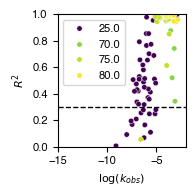

In [ ]:
# filter to nt_base = C
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df_c = df[df['nt_base'] == 'C']

fig, ax = plt.subplots(figsize=(2, 2))

# Main scatter plot
sns.scatterplot(data=df_c, x='log_kobs', y='r2', hue = 'temperature', palette = 'viridis', s = 15, ax=ax)
# set main axes labels

# draw horizontal line at r2 = 0.50
ax.axhline(0.30, color='black', linestyle='--', linewidth=1)
ax.set_xlabel(r'$\log(k_{obs})$')
ax.set_ylabel(r'$R^2$')

# set xlim -15 to -2
ax.set_xlim(-15, -2)
ax.set_ylim(0, 1)

# remove legend
ax.legend()

plt.tight_layout()
plt.savefig("r2_v_log_kobs_hiv_C.pdf")
plt.show()

In [ ]:
df_c

,fit_run_id,rg_id,nt_id,fit_kind,rg_label,temperature,probe,probe_conc,rt_protocol,buffer_id,...,buffer_name,nt_site,nt_base,kobs,log_kobs,log_kdeg,log_kobs_err,log_kdeg_err,r2,metadata_json
1,341268,83,320,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,19,C,0.002738,-5.900700,-7.919755,0.365600,0.0,0.652434,"{""base"": ""C"", ""fmod_run_ids"": [107, 108, 109, ..."
6,341273,83,325,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,24,C,0.049194,-3.011984,-7.919755,0.037547,0.0,0.994742,"{""base"": ""C"", ""fmod_run_ids"": [107, 108, 109, ..."
11,341278,83,330,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,29,C,0.000113,-9.084955,-7.919755,6.090321,0.0,0.006695,"{""base"": ""C"", ""fmod_run_ids"": [107, 108, 109, ..."
12,341279,83,331,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,30,C,0.002427,-6.021278,-7.919755,0.208343,0.0,0.852452,"{""base"": ""C"", ""fmod_run_ids"": [107, 108, 109, ..."
19,341286,83,338,round3_constrained,25_1_15,25.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,37,C,0.000941,-6.968944,-7.919755,0.700605,0.0,0.337714,"{""base"": ""C"", ""fmod_run_ids"": [107, 108, 109, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,339123,122,116,round3_constrained,80_2_12,80.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,37,C,0.033769,-3.388216,-2.886596,0.040181,0.0,0.992273,"{""base"": ""C"", ""fmod_run_ids"": [912, 913, 914, ..."
1175,339125,122,118,round3_constrained,80_2_12,80.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,39,C,0.029958,-3.507948,-2.886596,0.033024,0.0,0.994746,"{""base"": ""C"", ""fmod_run_ids"": [912, 913, 914, ..."
1177,339127,122,120,round3_constrained,80_2_12,80.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,41,C,0.030724,-3.482715,-2.886596,0.054066,0.0,0.986049,"{""base"": ""C"", ""fmod_run_ids"": [912, 913, 914, ..."
1180,339130,122,123,round3_constrained,80_2_12,80.0,etoh,0.015853,MRT,4,...,AlHashimiLab_NMR_NoMg_v2,44,C,0.037218,-3.290963,-2.886596,0.050138,0.0,0.988066,"{""base"": ""C"", ""fmod_run_ids"": [912, 913, 914, ..."


In [ ]:
# count of points with r2 >= 0.30
total_dfc = len(df_c)
count_r2_ge_50 = df_c[df_c['r2'] >= 0.30].shape[0]
print(f"Count of points with R^2 >= 0.30: {count_r2_ge_50}")
print(f"Total points: {total_dfc}")
print(f"Fraction of points with R^2 >= 0.30: {count_r2_ge_50 / total_dfc:.2f}")

Count of points with R^2 >= 0.30: 249
Total points: 280
Fraction of points with R^2 >= 0.30: 0.89


In [ ]:
df_a = df[df['nt_base'] == 'A']
total_dfa = len(df_a)
count_r2_ge_50_a = df_a[df_a['r2'] >= 0.30].shape[0]
print(f"Count of points with R^2 >= 0.50 (A): {count_r2_ge_50_a}")
print(f"Total points (A): {total_dfa}")
print(f"Fraction of points with R^2 >= 0.50 (A): {count_r2_ge_50_a / total_dfa:.2f}")

Count of points with R^2 >= 0.50 (A): 144
Total points (A): 144
Fraction of points with R^2 >= 0.50 (A): 1.00


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


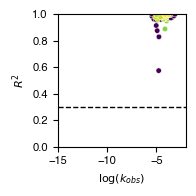

In [ ]:
# filter to nt_base = C
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df_c = df[df['nt_base'] == 'A']

fig, ax = plt.subplots(figsize=(2, 2))

# Main scatter plot
sns.scatterplot(data=df_c, x='log_kobs', y='r2', hue = 'temperature', palette = 'viridis', s = 15, ax=ax)
# set main axes labels

# draw horizontal line at r2 = 0.50
ax.axhline(0.30, color='black', linestyle='--', linewidth=1)
ax.set_xlabel(r'$\log(k_{obs})$')
ax.set_ylabel(r'$R^2$')


# set xlim -15 to -2
ax.set_xlim(-15, -2)
ax.set_ylim(0, 1)

# remove legend
ax.legend().remove()

plt.tight_layout()
plt.savefig("r2_v_log_kobs_hiv_A.pdf")
plt.show()